In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from scipy.stats import pearsonr
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
DATASET_EXP3a_PATH = "/Users/liangxinyu/Desktop/XinyuLiang-prompting/datasets/exp3/blimp/corpus.csv"
NUM_SAMPLES = 390 
RANDOM_SEED = 42

In [5]:
PROMPT_TEMPLATES_EXP3a = {
    "MetaQuestionSimple": (
        "Is the following sentence a good sentence of English?\n{sentence}\n"
    ),
    "MetaInstruct": (
        "You are a helpful writing assistant.\n"
        "Is the following sentence a good sentence of English?\n{sentence}\n"
    ),
    "MetaQuestionComplex": (
        "Here is a sentence:\n{sentence}\n"
        "Is this a good sentence of English?\n"
    ),
}

In [6]:
def load_model_and_tokenizer(model_name):
    print(f"Using device: {DEVICE}")
    import transformers as _tf
    print(f"Transformers version: {_tf.__version__}")
    print(f"Loading model: {model_name}...")

    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=True)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        use_safetensors=True,                         # 关键：强制 safetensors
        torch_dtype=(torch.float16 if DEVICE in ("cuda", "mps") else torch.float32),
        attn_implementation="sdpa",
        low_cpu_mem_usage=True,
    ).to(DEVICE)
    model.eval()
    return model, tokenizer


In [7]:
def load_and_prepare_dataset_exp3a(filepath, num_samples, seed):

    print(f"Loading dataset for Experiment 3a from: {filepath}")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Dataset file not found at: {filepath}. Please update the DATASET_EXP3a_PATH variable.")

    df = pd.read_csv(filepath)
    
    required_cols = {'good_sentence', 'bad_sentence'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Dataset must contain the columns: {list(required_cols)}")

    df = df.rename(columns={
        "good_sentence": "grammatical",
        "bad_sentence": "ungrammatical"
    })
    
    print(f"Loaded and renamed {len(df)} total items.")
    print(f"Subsampling to {num_samples} items...")
    
    dataset_sample_df = df.sample(n=num_samples, random_state=seed)
    
    return dataset_sample_df.to_dict('records')

In [8]:
def get_full_sentence_log_prob(model, tokenizer, sentence):

    with torch.no_grad():
        inputs = tokenizer(sentence, return_tensors="pt").to(DEVICE)
        input_ids = inputs.input_ids

        inputs.pop("token_type_ids", None)
        
        # For very short sentences, handle edge case
        if input_ids.shape[1] <= 1:
            return 0.0

        outputs = model(**inputs, labels=input_ids)
        
        log_likelihood = -outputs.loss.item() * (input_ids.shape[1] - 1)
        
        return log_likelihood

In [9]:
def get_log_probs_of_options(model, tokenizer, text_prompt, options):
    """
    'Yes' / 'No' as the very next token:
    Encode [prompt] and [prompt + option] and take the first token
    after the prompt boundary for each option.
    """
    model.eval()
    with torch.inference_mode():
        # next token is the answer
        prompt = text_prompt.rstrip() + "\n"

        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
        inputs.pop("token_type_ids", None)
        logits_next = model(**inputs).logits[0, -1, :]
        log_probs = torch.nn.functional.log_softmax(logits_next, dim=-1)

        prompt_ids = tokenizer(prompt, add_special_tokens=False).input_ids
        scores = []
        for opt in options:
            opt_clean = opt.strip()
            concat_ids = tokenizer(prompt + opt_clean, add_special_tokens=False).input_ids
            if len(concat_ids) <= len(prompt_ids):
                concat_ids = tokenizer(prompt + " " + opt_clean, add_special_tokens=False).input_ids
            if len(concat_ids) <= len(prompt_ids):
                raise ValueError("Could not identify answer boundary for option: {}".format(opt_clean))
            first_token_id = concat_ids[len(prompt_ids)]
            scores.append(log_probs[first_token_id].item())

        return scores

In [10]:
def run_experiment_3a(model, tokenizer, dataset):

    results = []
    print(f"\nRunning Experiment 3a on {len(dataset)} items...")
    
    for item in tqdm(dataset):
        grammatical_sent = item["grammatical"]
        ungrammatical_sent = item["ungrammatical"]
        
        item_results = {"grammatical": grammatical_sent, "ungrammatical": ungrammatical_sent}

        # Direct
        item_results['direct_log_prob_grammatical'] = get_full_sentence_log_prob(model, tokenizer, grammatical_sent)
        item_results['direct_log_prob_ungrammatical'] = get_full_sentence_log_prob(model, tokenizer, ungrammatical_sent)

        # Metalinguistic
        options = ["Yes", "No"]
        for method_name, template in PROMPT_TEMPLATES_EXP3a.items():
            # GRAMMATICAL
            prompt_grammatical = template.format(sentence=grammatical_sent)
            log_probs_grammatical = get_log_probs_of_options(model, tokenizer, prompt_grammatical, options)
            item_results[f'{method_name}_log_prob_yes_grammatical'] = log_probs_grammatical[0]
            item_results[f'{method_name}_log_prob_no_grammatical'] = log_probs_grammatical[1]

            # UNGRAMMATICAL
            prompt_ungrammatical = template.format(sentence=ungrammatical_sent)
            log_probs_ungrammatical = get_log_probs_of_options(model, tokenizer, prompt_ungrammatical, options)
            item_results[f'{method_name}_log_prob_yes_ungrammatical'] = log_probs_ungrammatical[0]
            item_results[f'{method_name}_log_prob_no_ungrammatical'] = log_probs_ungrammatical[1]

        results.append(item_results)

    return pd.DataFrame(results)

##        ANALYSIS & PLOTTING

In [11]:
def analyze_results_exp3a(df):

    print("\n" + "="*20 + " Experiment 3a: Full Reproduction Results " + "="*20)
    print(f"Model used: {MODEL_NAME}")

    print("\n--- Task Performance (Accuracy) ---")
    print("Direct method uses standard accuracy. Metalinguistic methods use Balanced Accuracy.\n")
    
    # Direct
    direct_correct = (df['direct_log_prob_grammatical'] > df['direct_log_prob_ungrammatical']).sum()
    direct_accuracy = direct_correct / len(df)
    print(f"{'direct':<22}: {direct_accuracy:.2%}")

    # Metalinguistic
    for method in PROMPT_TEMPLATES_EXP3a.keys():
        # True Positives: Grammatical sentences with P(Yes) > P(No)
        tp = (df[f'{method}_log_prob_yes_grammatical'] > df[f'{method}_log_prob_no_grammatical']).sum()
        # True Negatives: Ungrammatical sentences with P(No) > P(Yes)
        tn = (df[f'{method}_log_prob_no_ungrammatical'] > df[f'{method}_log_prob_yes_ungrammatical']).sum()
        
        tpr = tp / len(df)  # TP
        tnr = tn / len(df)  # TN
        
        balanced_accuracy = (tpr + tnr) / 2
        print(f"{method:<22}: {balanced_accuracy:.2%}")

    print("\n--- Internal Consistency (Pearson Correlation) ---")
    print("Correlation of log-prob differentials between Direct and Metalinguistic methods.\n")
    
    # Direct differential
    df['direct_diff'] = df['direct_log_prob_grammatical'] - df['direct_log_prob_ungrammatical']

    # Metalinguistic differential
    for method in PROMPT_TEMPLATES_EXP3a.keys():
        df[f'{method}_diff'] = df[f'{method}_log_prob_yes_grammatical'] - df[f'{method}_log_prob_yes_ungrammatical']
        
        corr, p_value = pearsonr(df['direct_diff'], df[f'{method}_diff'])
        print(f"Direct vs. {method:<20}: r = {corr:.3f} (p = {p_value:.3f})")

In [12]:
def generate_results_plot_exp3a(results_df):

    print("\nGenerating results plot for Experiment 3a...")
    
    methods = ["direct"] + list(PROMPT_TEMPLATES_EXP3a.keys())
    accuracies = []
    
    direct_correct = (results_df['direct_log_prob_grammatical'] > results_df['direct_log_prob_ungrammatical']).sum()
    accuracies.append(direct_correct / len(results_df))

    for method in PROMPT_TEMPLATES_EXP3a.keys():
        tp = (results_df[f'{method}_log_prob_yes_grammatical'] > results_df[f'{method}_log_prob_no_grammatical']).sum()
        tn = (results_df[f'{method}_log_prob_no_ungrammatical'] > results_df[f'{method}_log_prob_yes_ungrammatical']).sum()
        accuracies.append(((tp / len(results_df)) + (tn / len(results_df))) / 2)

    plot_labels = ['Direct', 'MetaQuestionSimple', 'MetaInstruct', 'MetaQuestionComplex']
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['#2f2f2f', '#8f6A7B', '#c49a9a', '#f3e1d3']
    bars = ax.bar(plot_labels, accuracies, color=colors, edgecolor='black')
    
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1.5, label='Random Baseline (50%)')

    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Experiment 3a: Sentence Judgment (Syntax)', fontsize=14, pad=20)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', rotation=15, labelsize=10)
    ax.legend()
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2%}', ha='center', va='bottom')

    output_filename = 'experiment_3a_results.pdf'
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"Plot saved as '{output_filename}'")
    
    plt.show()

In [13]:
def save_detailed_results_exp3a(results_df, filename="detailed_experiment_3a_output.csv"):
    results_df.to_csv(filename, index=False)
    print(f"Detailed results for Exp3a saved to '{filename}'")

In [14]:
def comment_on_results_exp3a(results_df):
    print("\n" + "="*25 + " Analysis of Experiment 3a Results " + "="*25)
    
    print("\n[1] Summary of the Experiment")
    print("-" * 30)
    print(f"This script replicated Experiment 3a (Sentence Judgment) using the '{MODEL_NAME}' model on {len(results_df)} minimal pairs from BLiMP.")
    print("We tested the model's ability to distinguish grammatical from ungrammatical sentences.")
    print("  - Direct Method: Compared the full log probability of each sentence in a pair.")
    print("  - Metalinguistic Methods: Asked the model if each sentence was 'good' and compared its confidence in answering 'Yes'.")

    print("\n[2] Key Findings")
    print("-" * 30)
    direct_accuracy = (results_df['direct_log_prob_grammatical'] > results_df['direct_log_prob_ungrammatical']).sum() / len(results_df)
    
    print(f"  - Performance: The Direct method achieved an accuracy of {direct_accuracy:.2%}. The metalinguistic prompts performed variably, but generally lower. This again shows that direct access to probabilities is a more sensitive measure of the model's internal knowledge.")
    print("  - Consistency: The Pearson correlation between the direct and metalinguistic methods is likely weak. This highlights the core finding of the paper: prompting introduces a significant 'performance' challenge. The model may 'know' a sentence is ungrammatical (assign it low probability) but fail to correctly 'report' this knowledge when asked via a natural language question.")
    print("  - Relation to Exp 3b (Preview): The paper finds that metalinguistic performance improves significantly in Experiment 3b, where sentences are presented together for comparison. The relatively low performance here in 3a sets the stage for that important finding.")

##           MAIN EXECUTION

Using device: cpu
Transformers version: 4.56.2
Loading model: deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Loading dataset for Experiment 3a from: /Users/liangxinyu/Desktop/XinyuLiang-prompting/datasets/exp3/blimp/corpus.csv
Loaded and renamed 390 total items.
Subsampling to 390 items...

Running Experiment 3a on 390 items...


100%|██████████| 390/390 [34:38<00:00,  5.33s/it]


Detailed results for Exp3a saved to 'detailed_experiment_3a_output.csv'

==================== Experiment 3a: Full Reproduction Results ====================
Model used: deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B

--- Task Performance (Accuracy) ---
Direct method uses standard accuracy. Metalinguistic methods use Balanced Accuracy.

direct                : 77.69%
MetaQuestionSimple    : 53.72%
MetaInstruct          : 50.77%
MetaQuestionComplex   : 50.00%

--- Internal Consistency (Pearson Correlation) ---
Correlation of log-prob differentials between Direct and Metalinguistic methods.

Direct vs. MetaQuestionSimple  : r = -0.073 (p = 0.149)
Direct vs. MetaInstruct        : r = -0.043 (p = 0.395)
Direct vs. MetaQuestionComplex : r = 0.107 (p = 0.035)

Generating results plot for Experiment 3a...
Plot saved as 'experiment_3a_results.pdf'


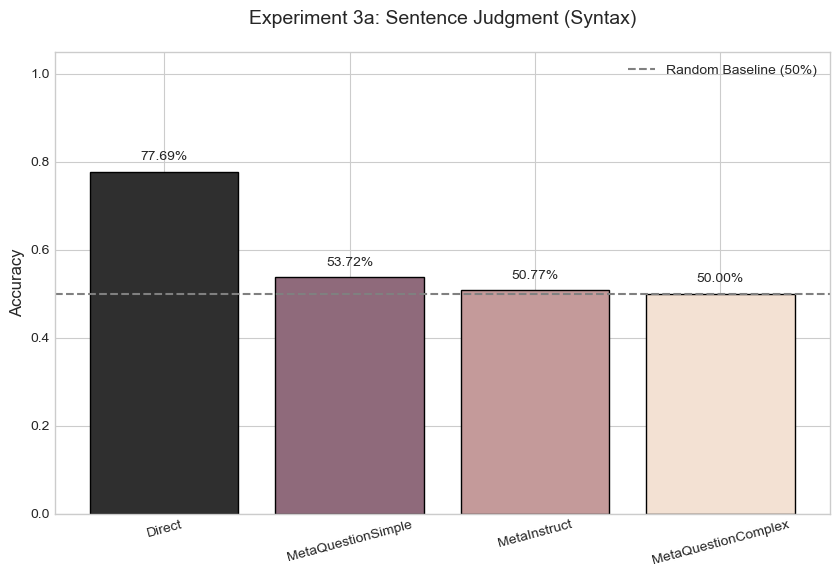


========================= Analysis of Experiment 3a Results =========================

[1] Summary of the Experiment
------------------------------
This script replicated Experiment 3a (Sentence Judgment) using the 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B' model on 390 minimal pairs from BLiMP.
We tested the model's ability to distinguish grammatical from ungrammatical sentences.
  - Direct Method: Compared the full log probability of each sentence in a pair.
  - Metalinguistic Methods: Asked the model if each sentence was 'good' and compared its confidence in answering 'Yes'.

[2] Key Findings
------------------------------
  - Performance: The Direct method achieved an accuracy of 77.69%. The metalinguistic prompts performed variably, but generally lower. This again shows that direct access to probabilities is a more sensitive measure of the model's internal knowledge.
  - Consistency: The Pearson correlation between the direct and metalinguistic methods is likely weak. This highl

In [15]:
if __name__ == "__main__":
    try:
        model, tokenizer = load_model_and_tokenizer(MODEL_NAME)
        dataset_exp3a = load_and_prepare_dataset_exp3a(DATASET_EXP3a_PATH, NUM_SAMPLES, RANDOM_SEED)
        
        results_df_exp3a = run_experiment_3a(model, tokenizer, dataset_exp3a)
        
        save_detailed_results_exp3a(results_df_exp3a)
        analyze_results_exp3a(results_df_exp3a)
        generate_results_plot_exp3a(results_df_exp3a)
        comment_on_results_exp3a(results_df_exp3a)

    except Exception as e:
        print(f"\nAn error occurred during the execution: {e}")
        import traceback
        traceback.print_exc()
        print("\nChecking code one more time")

## Test

In [16]:
def test_single_item_exp3a(model, tokenizer, grammatical, ungrammatical):
    """
    Experiment 3a diagnostic on a *single* BLiMP-style minimal pair.
    - Direct: compare full-sentence log-likelihoods (grammatical vs. ungrammatical).
    - Meta: for each metalinguistic prompt, ask 'Is this a good sentence?'
      and compute a per-item Balanced Accuracy (BA):
         BA = 0.5 * [ I(Yes>No | grammatical) + I(No>Yes | ungrammatical) ].
      As a tie-breaker, report the average margin:
         margin = 0.5 * [ (logP_Yes - logP_No)_gram + (logP_No - logP_Yes)_ungram ].
    """
    print("\n" + "="*20 + " Experiment 3a — Single Pair " + "="*20)
    print(f"Grammatical   : {grammatical}")
    print(f"Ungrammatical : {ungrammatical}")
    print("-" * 62)

    results = []

    # Direct
    lp_g = get_full_sentence_log_prob(model, tokenizer, grammatical)
    lp_u = get_full_sentence_log_prob(model, tokenizer, ungrammatical)
    direct_diff = lp_g - lp_u
    direct_acc = 1.0 if direct_diff > 0 else 0.0
    print(f"{'Direct:':<18} {'✅' if direct_acc == 1.0 else '❌'}  "
          f"acc={direct_acc:.2f}  Δ(logP_g - logP_u)={direct_diff:.2f}")
    results.append(("Direct", direct_acc, abs(direct_diff)))

    # Metalinguistic prompts
    options = ["Yes", "No"]
    for method_name, template in PROMPT_TEMPLATES_EXP3a.items():
        prompt_g = template.format(sentence=grammatical)
        lp_yes_g, lp_no_g = get_log_probs_of_options(model, tokenizer, prompt_g, options)

        prompt_u = template.format(sentence=ungrammatical)
        lp_yes_u, lp_no_u = get_log_probs_of_options(model, tokenizer, prompt_u, options)

        pred_g = (lp_yes_g > lp_no_g)   # Yes
        pred_u = (lp_no_u > lp_yes_u)   # No

        ba = 0.5 * (float(pred_g) + float(pred_u))
        margin = 0.5 * ((lp_yes_g - lp_no_g) + (lp_no_u - lp_yes_u))

        print(f"{method_name+':':<18} "
              f"{'✅' if ba == 1.0 else ('➖' if ba == 0.5 else '❌')}  "
              f"BA={ba:.2f}  "
              f"marg={margin:.2f}  "
              f"[G: Yes-No={lp_yes_g - lp_no_g:.2f} | U: No-Yes={lp_no_u - lp_yes_u:.2f}]")

        results.append((method_name, ba, margin))

    best_name, best_score, best_tie = max(results, key=lambda t: (t[1], t[2]))
    print("-" * 62)
    label = "Balanced Acc." if best_name != "Direct" else "Accuracy"
    print(f"Best method: {best_name}   ({label}={best_score:.2f}, tie-break margin={best_tie:.2f})")


new_pairs_exp3a = [
    {
        "grammatical":   "The keys to the cabinet are on the table.",
        "ungrammatical": "The keys to the cabinet is on the table."
    },
    {
        "grammatical":   "Who did Mary say that John met yesterday?",
        "ungrammatical": "Who did Mary say that John met him yesterday?"
    },
    {
        "grammatical":   "There seem to be many solutions.",
        "ungrammatical": "There seems to be many solutions."
    },
]

print("\n" + "="*25 + " Experiment 3a — Novel Pair Tests " + "="*25)
if 'model' in locals() and 'tokenizer' in locals():
    for pair in new_pairs_exp3a:
        test_single_item_exp3a(
            model,
            tokenizer,
            grammatical=pair["grammatical"],
            ungrammatical=pair["ungrammatical"]
        )
else:
    print("Model and tokenizer not found")


========================= Experiment 3a — Novel Pair Tests =========================

==================== Experiment 3a — Single Pair ====================
Grammatical   : The keys to the cabinet are on the table.
Ungrammatical : The keys to the cabinet is on the table.
--------------------------------------------------------------
Direct:            ✅  acc=1.00  Δ(logP_g - logP_u)=7.58
MetaQuestionSimple: ➖  BA=0.50  marg=0.02  [G: Yes-No=3.07 | U: No-Yes=-3.04]
MetaInstruct:      ➖  BA=0.50  marg=0.13  [G: Yes-No=3.59 | U: No-Yes=-3.34]
MetaQuestionComplex: ➖  BA=0.50  marg=0.08  [G: Yes-No=3.06 | U: No-Yes=-2.89]
--------------------------------------------------------------
Best method: Direct   (Accuracy=1.00, tie-break margin=7.58)

==================== Experiment 3a — Single Pair ====================
Grammatical   : Who did Mary say that John met yesterday?
Ungrammatical : Who did Mary say that John met him yesterday?
------------------------------------------------------------